# Using multi-output model to classify Delhi Weather Data
Task: predict 4 weather metrics into the future - mean temperature, humidity, wind speed and mean pressure - and classify comfort (comfortable = 1, not comfortable = 0)  

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
import keras_tuner as kt

## Process train and test data

In [3]:
train = pd.read_csv('../Datasets/Delhi Climate/DailyDelhiClimateTrain.csv', index_col=0)
train.shape

(1462, 5)

In [4]:
test = pd.read_csv('../Datasets/Delhi Climate/DailyDelhiClimateTest.csv', index_col = 0)
test.shape

(114, 5)

In [5]:
def normalise(data, min, max):
    data = data - min
    data = data / max
    return data

train = train.values
train_normed = normalise(train, train.min(axis=0), train.max(axis=0))
test = test.values
test_normed = normalise(test, train.min(axis=0), train.max(axis=0))

## Plot train data

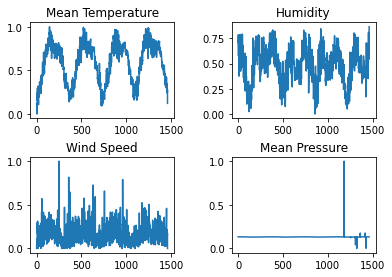

In [6]:
# fig, ax = plt.subplots(2, 2)
# # fig.suptitle('Delhi Weather Features')
# ax[0, 0].plot(range(len(train['meantemp'])), train['meantemp'])
# ax[0, 0].set_title('Mean Temperature')
# ax[0, 1].plot(range(len(train['humidity'])), train['humidity'])
# ax[0, 1].set_title('Humidity')
# ax[1, 0].plot(range(len(train['wind_speed'])), train['wind_speed'])
# ax[1, 0].set_title('Wind Speed')
# ax[1, 1].plot(range(len(train['meanpressure'])), train['meanpressure'])
# ax[1, 1].set_title('Mean Pressure')

# plt.subplots_adjust(left = 0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)
# plt.show()

## Create features and labels

In [7]:
def windowed_dataset(series, n_past, n_future, batch_size, shift=1):

    # n_past = number of timesteps to look back (x or input to model)
    # n_future = number of timesteps to predict (y or output of model)

    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(size=n_past + n_future, shift=shift, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(n_past + n_future)) # flat_map returns a non-iterable, unlike map which returns a list
    dataset = dataset.map(lambda window: (window[:n_past, :-1], (window[:n_past, :-1], window[n_past:, -1])))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

batch_size = 32 # affects performance, but impact is not straightforward (i.e. larger batch_size =/= better performance)
n_past = 10
n_future = 1
shift = 1

test_ds = windowed_dataset(series=test_normed, batch_size=batch_size, n_past=n_past, n_future=n_future, shift=shift)
train_ds = windowed_dataset(series=train_normed, batch_size=batch_size, n_past=n_past, n_future=n_future, shift=shift)

In [8]:
def windowed_dataset_structure(dataset):
    for x, (p, c) in dataset:
        print(np.array(x).shape, [np.array(p).shape, np.array(c).shape])

windowed_dataset_structure(test_ds)
print()
windowed_dataset_structure(train_ds)

(32, 10, 4) [(32, 10, 4), (32, 1)]
(32, 10, 4) [(32, 10, 4), (32, 1)]
(32, 10, 4) [(32, 10, 4), (32, 1)]
(8, 10, 4) [(8, 10, 4), (8, 1)]

(32, 10, 4) [(32, 10, 4), (32, 1)]
(32, 10, 4) [(32, 10, 4), (32, 1)]
(32, 10, 4) [(32, 10, 4), (32, 1)]
(32, 10, 4) [(32, 10, 4), (32, 1)]
(32, 10, 4) [(32, 10, 4), (32, 1)]
(32, 10, 4) [(32, 10, 4), (32, 1)]
(32, 10, 4) [(32, 10, 4), (32, 1)]
(32, 10, 4) [(32, 10, 4), (32, 1)]
(32, 10, 4) [(32, 10, 4), (32, 1)]
(32, 10, 4) [(32, 10, 4), (32, 1)]
(32, 10, 4) [(32, 10, 4), (32, 1)]
(32, 10, 4) [(32, 10, 4), (32, 1)]
(32, 10, 4) [(32, 10, 4), (32, 1)]
(32, 10, 4) [(32, 10, 4), (32, 1)]
(32, 10, 4) [(32, 10, 4), (32, 1)]
(32, 10, 4) [(32, 10, 4), (32, 1)]
(32, 10, 4) [(32, 10, 4), (32, 1)]
(32, 10, 4) [(32, 10, 4), (32, 1)]
(32, 10, 4) [(32, 10, 4), (32, 1)]
(32, 10, 4) [(32, 10, 4), (32, 1)]
(32, 10, 4) [(32, 10, 4), (32, 1)]
(32, 10, 4) [(32, 10, 4), (32, 1)]
(32, 10, 4) [(32, 10, 4), (32, 1)]
(32, 10, 4) [(32, 10, 4), (32, 1)]
(32, 10, 4) [(32, 10, 

## Build Model

In [17]:
xIn = Input((n_past, 4))
x = LSTM(64, return_sequences=True)(xIn) # set return_sequences = True if there's an LSTM layer afterwards
x = LSTM(64, return_sequences=True)(x)

x = Dense(64, activation='swish')(x)
x = Dense(64, activation='swish')(x)

# meantemp_output = Dense(n_future, activation='swish', name='meantemp_output')(x)

# humidity_output = Dense(n_future, activation='swish', name='humidity_output')(x)

# wind_speed_output = Dense(n_future, activation='swish', name='wind_speed_output')(x)

# meanpressure_output = Dense(n_future, activation='swish', name='meanpressure_output')(x)
x = LSTM(4, return_sequences=True)(x)
weather_output = Dense(n_future, activation='swish', name='weather_output')(x)

x = Flatten()(weather_output)
x = Dense(64, activation='swish')(x)

comfort_output = Dense(n_future, activation='sigmoid', name='comfort_output')(x)

model = Model(inputs=xIn, outputs=[weather_output, comfort_output])
model.compile(optimizer='adam', 
              loss={
                  'weather_output': 'mse', 
                  'comfort_output': 'binary_crossentropy'},
              loss_weights={
                  'weather_output': 1,
                  'comfort_output': 2},
              metrics={
                  'weather_output': 'mse', 
                  'comfort_output': 'accuracy'})
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 10, 4)]           0         
                                                                 
 lstm_5 (LSTM)               (None, 10, 64)            17664     
                                                                 
 lstm_6 (LSTM)               (None, 10, 64)            33024     
                                                                 
 dense_6 (Dense)             (None, 10, 64)            4160      
                                                                 
 dense_7 (Dense)             (None, 10, 64)            4160      
                                                                 
 lstm_7 (LSTM)               (None, 10, 4)             1104      
                                                                 
 weather_output (Dense)      (None, 10, 1)             5   

In [18]:
epochs = 30

callbacks = [
    tf.keras.callbacks.ModelCheckpoint('./7_best_model', monitor='val_weather_output_loss', save_best_only=True),
    # tf.keras.callbacks.EarlyStopping(monitor='val_weather_output_loss', patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_weather_output_loss', factor=0.1, patience=3, verbose=1)
]

history = model.fit(train_ds, validation_data=test_ds, batch_size=32, epochs=epochs, callbacks=callbacks, use_multiprocessing=True)

Epoch 1/30
     46/Unknown - 8s 30ms/step - loss: 0.6936 - weather_output_loss: 0.0910 - comfort_output_loss: 0.6026 - weather_output_mse: 0.0910 - comfort_output_accuracy: 0.7610

INFO:tensorflow:Assets written to: .\7_best_model\assets


INFO:tensorflow:Assets written to: .\7_best_model\assets


46/46 [==============================] - 24s 380ms/step - loss: 0.6936 - weather_output_loss: 0.0910 - comfort_output_loss: 0.6026 - weather_output_mse: 0.0910 - comfort_output_accuracy: 0.7610 - val_loss: 0.6139 - val_weather_output_loss: 0.0489 - val_comfort_output_loss: 0.5651 - val_weather_output_mse: 0.0489 - val_comfort_output_accuracy: 0.7596 - lr: 0.0010
Epoch 2/30
45/46 [============================>.] - ETA: 0s - loss: 0.6086 - weather_output_loss: 0.0665 - comfort_output_loss: 0.5421 - weather_output_mse: 0.0665 - comfort_output_accuracy: 0.7771

INFO:tensorflow:Assets written to: .\7_best_model\assets


INFO:tensorflow:Assets written to: .\7_best_model\assets


46/46 [==============================] - 15s 323ms/step - loss: 0.6065 - weather_output_loss: 0.0663 - comfort_output_loss: 0.5402 - weather_output_mse: 0.0663 - comfort_output_accuracy: 0.7789 - val_loss: 0.5962 - val_weather_output_loss: 0.0433 - val_comfort_output_loss: 0.5529 - val_weather_output_mse: 0.0433 - val_comfort_output_accuracy: 0.7596 - lr: 0.0010
Epoch 3/30
46/46 [==============================] - ETA: 0s - loss: 0.5943 - weather_output_loss: 0.0599 - comfort_output_loss: 0.5344 - weather_output_mse: 0.0599 - comfort_output_accuracy: 0.7789

INFO:tensorflow:Assets written to: .\7_best_model\assets


INFO:tensorflow:Assets written to: .\7_best_model\assets


46/46 [==============================] - 18s 398ms/step - loss: 0.5943 - weather_output_loss: 0.0599 - comfort_output_loss: 0.5344 - weather_output_mse: 0.0599 - comfort_output_accuracy: 0.7789 - val_loss: 0.5921 - val_weather_output_loss: 0.0408 - val_comfort_output_loss: 0.5513 - val_weather_output_mse: 0.0408 - val_comfort_output_accuracy: 0.7596 - lr: 0.0010
Epoch 4/30
46/46 [==============================] - ETA: 0s - loss: 0.5903 - weather_output_loss: 0.0575 - comfort_output_loss: 0.5328 - weather_output_mse: 0.0575 - comfort_output_accuracy: 0.7789

INFO:tensorflow:Assets written to: .\7_best_model\assets


INFO:tensorflow:Assets written to: .\7_best_model\assets


46/46 [==============================] - 13s 288ms/step - loss: 0.5903 - weather_output_loss: 0.0575 - comfort_output_loss: 0.5328 - weather_output_mse: 0.0575 - comfort_output_accuracy: 0.7789 - val_loss: 0.5901 - val_weather_output_loss: 0.0392 - val_comfort_output_loss: 0.5509 - val_weather_output_mse: 0.0392 - val_comfort_output_accuracy: 0.7596 - lr: 0.0010
Epoch 5/30
44/46 [===========================>..] - ETA: 0s - loss: 0.5822 - weather_output_loss: 0.0568 - comfort_output_loss: 0.5254 - weather_output_mse: 0.0568 - comfort_output_accuracy: 0.7848

INFO:tensorflow:Assets written to: .\7_best_model\assets


INFO:tensorflow:Assets written to: .\7_best_model\assets


46/46 [==============================] - 14s 306ms/step - loss: 0.5883 - weather_output_loss: 0.0561 - comfort_output_loss: 0.5322 - weather_output_mse: 0.0561 - comfort_output_accuracy: 0.7789 - val_loss: 0.5887 - val_weather_output_loss: 0.0381 - val_comfort_output_loss: 0.5506 - val_weather_output_mse: 0.0381 - val_comfort_output_accuracy: 0.7596 - lr: 0.0010
Epoch 6/30
46/46 [==============================] - ETA: 0s - loss: 0.5867 - weather_output_loss: 0.0552 - comfort_output_loss: 0.5315 - weather_output_mse: 0.0552 - comfort_output_accuracy: 0.7789

INFO:tensorflow:Assets written to: .\7_best_model\assets


INFO:tensorflow:Assets written to: .\7_best_model\assets


46/46 [==============================] - 14s 320ms/step - loss: 0.5867 - weather_output_loss: 0.0552 - comfort_output_loss: 0.5315 - weather_output_mse: 0.0552 - comfort_output_accuracy: 0.7789 - val_loss: 0.5875 - val_weather_output_loss: 0.0376 - val_comfort_output_loss: 0.5500 - val_weather_output_mse: 0.0376 - val_comfort_output_accuracy: 0.7596 - lr: 0.0010
Epoch 7/30
46/46 [==============================] - 1s 28ms/step - loss: 0.5845 - weather_output_loss: 0.0549 - comfort_output_loss: 0.5296 - weather_output_mse: 0.0549 - comfort_output_accuracy: 0.7789 - val_loss: 0.5854 - val_weather_output_loss: 0.0394 - val_comfort_output_loss: 0.5460 - val_weather_output_mse: 0.0394 - val_comfort_output_accuracy: 0.7596 - lr: 0.0010
Epoch 8/30
46/46 [==============================] - 1s 28ms/step - loss: 0.5797 - weather_output_loss: 0.0572 - comfort_output_loss: 0.5225 - weather_output_mse: 0.0572 - comfort_output_accuracy: 0.7789 - val_loss: 0.5852 - val_weather_output_loss: 0.0459 - val

## Plot accuracy and loss

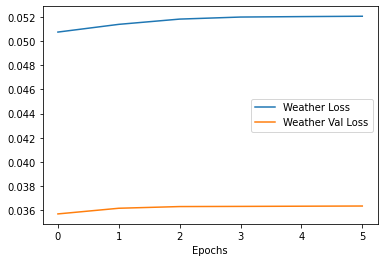

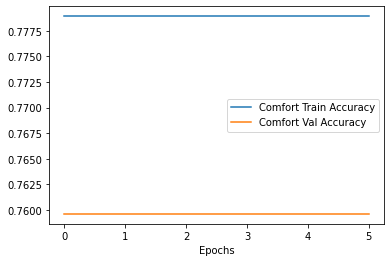

In [14]:
plt.plot(history.history['weather_output_loss'], label='Weather Loss')
plt.plot(history.history['val_weather_output_loss'], label='Weather Val Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

plt.plot(history.history['comfort_output_accuracy'], label='Comfort Train Accuracy')
plt.plot(history.history['val_comfort_output_accuracy'], label='Comfort Val Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show()